## Raw Data Preprocessing
- 1) Find the below information from the raw data
    - a) KODEX KOSDAQ 150 LEVERAGE (233740)
        - i) Limit Order: B7011KR7233740
        - ii) Execution: A3011KR7233740

In [3]:
import gzip
import copy
import matplotlib.pyplot as plts
import numpy as np
import pandas as pd
import datetime
import time
import os
from openpyxl import *
from bars import *
pd.options.mode.chained_assignment = None
%matplotlib inline

## Read_Cleaned_File

In [5]:
df = pd.read_csv(save_path + '233740_20190321.csv')
df['mid_price'] = (df['long_lvl_1_p'] + df['short_lvl_1_p']) / 2
df['time'] = df['time'].apply(lambda x: datetime.datetime.strptime(x, '%Y%m%d %H:%M:%S.%f').timestamp())
df['time'] = df['time'].apply(lambda x: datetime.datetime.fromtimestamp(x))
df = df.set_index('time')

C:\Users\Jay\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
time_diff = [np.nan]
for idx in range(len(df)):
    
    if idx == 0:
        continue
    
    time_diff.append((df.index[idx] - df.index[idx-1]).total_seconds())

df['time_diff'] = time_diff

In [8]:
df = df[(df.index >= df[df['long_or_short'] == ' '].index[0]) & (df.index <= df[df['long_or_short'] == ' '].index[1])]
df = df[df['code'] == 'A3'] # executino_data

### 0) Time Bar

In [11]:
bars = BarSeries(df)
time_bars = bars.process_ticks(frequency='1Min')

In [15]:
time_bars.head()

,open,high,low,close,exe_q,time_diff
time,,,,,,
2019-03-21 09:01:00,13337.5,13360.0,13317.5,13357.5,185992,0.174822
2019-03-21 09:02:00,13357.5,13407.5,13355.0,13395.0,197845,0.150989
2019-03-21 09:03:00,13390.0,13392.5,13355.0,13365.0,71623,0.103993
2019-03-21 09:04:00,13367.5,13382.5,13347.5,13365.0,70147,0.049920
2019-03-21 09:05:00,13365.0,13365.0,13270.0,13287.5,104482,0.123512


### 1) Tick Bar

In [16]:
bars = TickBarSeries(df)
tick_bars = bars.process_ticks(frequency = 100)

In [17]:
tick_bars.head()

,close,high,low,open,time_diff,volume
datetime,,,,,,
2019-03-21 09:00:54.709161,13355.0,13360.0,13317.5,13337.5,0.181510,177624
2019-03-21 09:01:20.520582,13390.0,13392.5,13347.5,13352.5,0.141864,95137
2019-03-21 09:01:50.709656,13405.0,13405.0,13380.0,13390.0,0.150715,92850
2019-03-21 09:02:20.165009,13360.0,13407.5,13355.0,13405.0,0.159529,49791
2019-03-21 09:02:47.022491,13362.5,13370.0,13357.5,13360.0,0.086617,33886


### 2) Volume Bar

In [24]:
bars = VolumeBarSeries(df)
volume_bars = bars.process_ticks(frequency = 1000000)

In [25]:
volume_bars.head()

,close,high,low,open,time_diff,volume
datetime,,,,,,
2019-03-21 09:09:29.851666,13412.5,13435.0,13270.0,13337.5,0.080768,1000147.0
2019-03-21 09:23:22.722206,13445.0,13445.0,13317.5,13412.5,0.080464,1001416.0
2019-03-21 09:30:45.649179,13520.0,13542.5,13447.5,13447.5,0.058990,1000899.0
2019-03-21 09:49:04.835661,13347.5,13532.5,13347.5,13517.5,0.080177,1007698.0
2019-03-21 10:22:40.122284,13355.0,13425.0,13322.5,13347.5,0.096937,1009278.0


### 3) Dollar Bar

In [26]:
bars = DollarBarSeries(df)
dollar_bars = bars.process_ticks(frequency = 1000000000)

In [27]:
dollar_bars.head()

,close,dollar,high,low,open,time_diff,volume
datetime,,,,,,,
2019-03-21 09:00:09.100554,13337.5,1.139009e+09,13337.5,13337.5,13337.5,0.082240,85399
2019-03-21 09:00:47.100023,13347.5,1.078131e+09,13347.5,13317.5,13337.5,0.189722,80856
2019-03-21 09:01:11.622146,13365.0,1.007207e+09,13372.5,13347.5,13347.5,0.145264,75390
2019-03-21 09:01:40.992279,13387.5,1.068957e+09,13392.5,13365.0,13365.0,0.154370,79878
2019-03-21 09:02:05.996083,13375.0,1.000437e+09,13407.5,13375.0,13390.0,0.155892,74695


### 4) Imbalance Bar

In [28]:
bars = ImbalanceTickBarSeries(df)
imbtick_bars = bars.process_ticks(init = 100, min_bar = 50, max_bar = 1000)

C:\Users\win\bars.py:217: RuntimeWarning: overflow encountered in power
  scale_arr = scale ** r
C:\Users\win\bars.py:223: RuntimeWarning: invalid value encountered in multiply
  out = offset + cumsums * scale_arr[::-1]
C:\Users\win\bars.py:221: RuntimeWarning: invalid value encountered in multiply
  mult = data*pw0*scale_arr


In [29]:
imbtick_bars

,close,high,low,open,volume
datetime,,,,,
2019-03-21 09:01:44.295710,13392.5,13392.5,13347.5,13352.5,162444
2019-03-21 09:02:19.052581,13362.5,13407.5,13355.0,13392.5,73471
2019-03-21 09:02:42.791166,13370.0,13370.0,13357.5,13360.0,30989
2019-03-21 09:03:08.786617,13377.5,13380.0,13362.5,13370.0,21926
2019-03-21 09:03:13.269169,13370.0,13382.5,13370.0,13380.0,8432
2019-03-21 09:03:34.864673,13365.0,13370.0,13347.5,13370.0,37255
2019-03-21 09:03:41.086078,13367.5,13367.5,13365.0,13365.0,6948
2019-03-21 09:07:21.164294,13375.0,13375.0,13270.0,13367.5,245714
2019-03-21 09:08:27.352645,13427.5,13427.5,13342.5,13375.0,128796


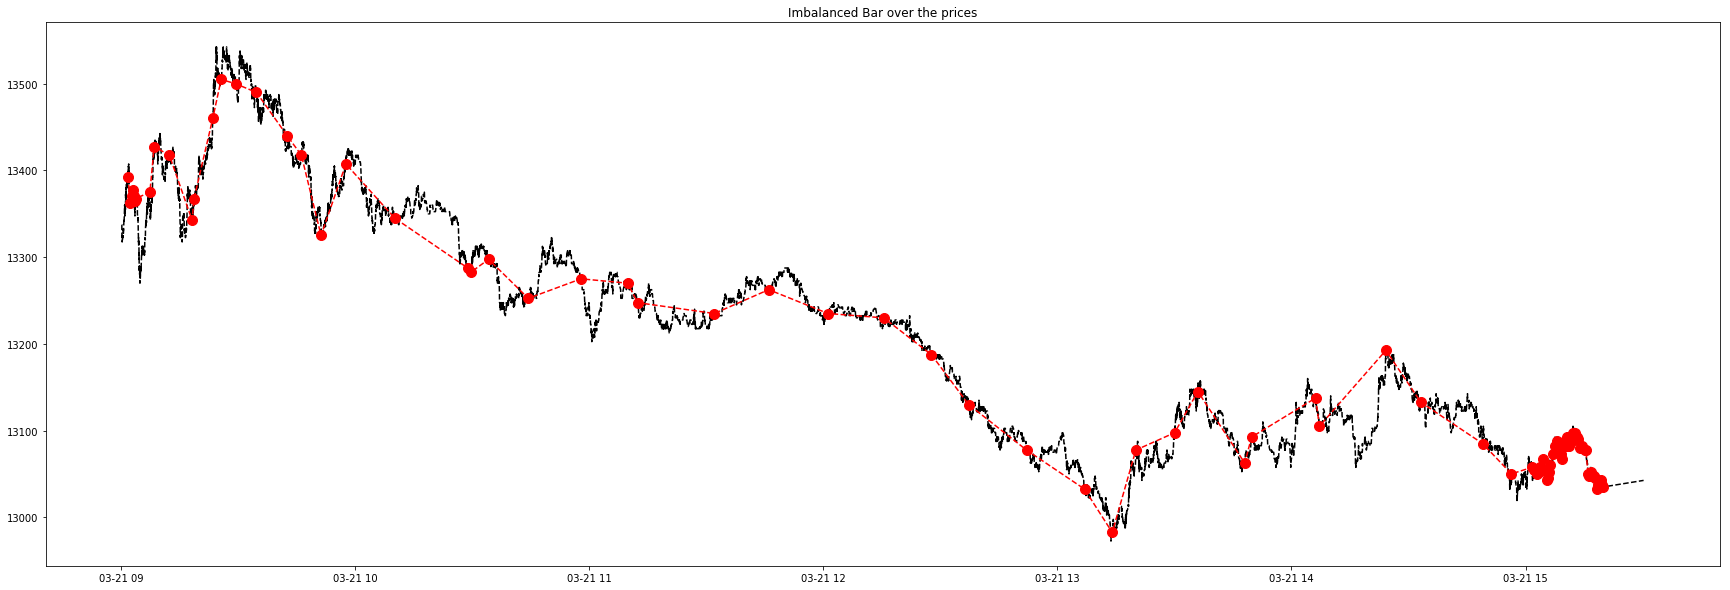

In [31]:
plt.figure(figsize=(30,10))
plt.title('Imbalanced Bar over the prices')
plt.plot(df.index.values[:], df.mid_price.values[:], label='raw_prices', ls = '--', color='black')
plt.plot(imbtick_bars.index.values[:],imbtick_bars.close.values[:], label='imbtick_bars', ls= '--',markersize=10, marker='o', color='red')
plt.show()